## Zindi-Sendy Kickoff Tutorial
**by Steven Simba on October 26, 2019 <br>**
***



## The machine Learning pipeline we be will follow as follows

1. Import data
2. Data cleaning and formating
3. Exploratory data analysis
4. Feature engineering and selection
5. Building Models

### 1) Import Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')

In [2]:
#Train_Masked has extra columns: Delivery destination (day, month, time)

train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
riders_df = pd.read_csv("Riders.csv")

print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head()

(21201, 29) (7068, 25) (960, 5)


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [3]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival


In [4]:
#Checking how our target variable was calculated

labels = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(labels.dt.seconds[:5]), list(train_df['Time from Pickup to Arrival'][:5])

([745, 1993, 455, 1341, 1214], [745, 1993, 455, 1341, 1214])

In [5]:
#Drop data not available in test, Pickup Time + label = Arrival times

train_df = train_df.drop(['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time'], axis=1)


In [6]:
#Create (full_df = train + test) ** caution (dont shuffle, avoid drop/adding rows)
#explore training, make (column) changes to full, later we use the border to separate
#Be careful of information leakage

border = train_df.shape[0]
test_df['Time from Pickup to Arrival'] = [np.nan]* test_df.shape[0]
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

train_df.shape, test_df.shape, full_df.shape

((21201, 26), (7068, 26), (28269, 26))

### 2) DATA CLEANING AND FORMATING

In [7]:
# Check features and their data types (confirm) -> numeric, date, object,datetime 
# missing values in temperature and precipitation
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28269 entries, 0 to 28268
Data columns (total 26 columns):
Order No                                28269 non-null object
User Id                                 28269 non-null object
Vehicle Type                            28269 non-null object
Platform Type                           28269 non-null int64
Personal or Business                    28269 non-null object
Placement - Day of Month                28269 non-null int64
Placement - Weekday (Mo = 1)            28269 non-null int64
Placement - Time                        28269 non-null object
Confirmation - Day of Month             28269 non-null int64
Confirmation - Weekday (Mo = 1)         28269 non-null int64
Confirmation - Time                     28269 non-null object
Arrival at Pickup - Day of Month        28269 non-null int64
Arrival at Pickup - Weekday (Mo = 1)    28269 non-null int64
Arrival at Pickup - Time                28269 non-null object
Pickup - Day of Month         

In [8]:
#Renaming columns (shorten, remove space, standardize)
new_names = {"Order No": "Order_No", "User Id": "User_Id", "Vehicle Type": "Vehicle_Type",
    "Personal or Business": "Personal_Business", "Placement - Day of Month": "Pla_Mon",
    "Placement - Weekday (Mo = 1)": "Pla_Weekday", "Placement - Time": "Pla_Time", 
    "Confirmation - Day of Month":"Con_Day_Mon", "Confirmation - Weekday (Mo = 1)": "Con_Weekday","Confirmation - Time": "Con_Time", 
    "Arrival at Pickup - Day of Month": "Arr_Pic_Mon", "Arrival at Pickup - Weekday (Mo = 1)": "Arr_Pic_Weekday", 
                "Arrival at Pickup - Time": "Arr_Pic_Time", "Platform Type": "Platform_Type",
     "Pickup - Day of Month": "Pickup_Mon", "Pickup - Weekday (Mo = 1)": "Pickup_Weekday",           
    "Pickup - Time": "Pickup_Time",  "Distance (KM)": "Distance(km)",
    "Precipitation in millimeters": "Precipitation(mm)", "Pickup Lat": "Pickup_Lat", "Pickup Long": "Pickup_Lon", 
    "Destination Lat": "Destination_Lat", "Destination Long":"Destination_Lon", "Rider Id": "Rider_Id",
                            "Time from Pickup to Arrival": "Time_Pic_Arr"
                           }

full_df = full_df.rename(columns=new_names)
full_df.columns

Index(['Order_No', 'User_Id', 'Vehicle_Type', 'Platform_Type',
       'Personal_Business', 'Pla_Mon', 'Pla_Weekday', 'Pla_Time',
       'Con_Day_Mon', 'Con_Weekday', 'Con_Time', 'Arr_Pic_Mon',
       'Arr_Pic_Weekday', 'Arr_Pic_Time', 'Pickup_Mon', 'Pickup_Weekday',
       'Pickup_Time', 'Distance(km)', 'Temperature', 'Precipitation(mm)',
       'Pickup_Lat', 'Pickup_Lon', 'Destination_Lat', 'Destination_Lon',
       'Rider_Id', 'Time_Pic_Arr'],
      dtype='object')

In [9]:
#Convert Time from 12H to 24H

def convert_to_24hrs(fulldf):
    for col in fulldf.columns:
        if col.endswith("Time"):
            fulldf[col] = pd.to_datetime(fulldf[col], format='%I:%M:%S %p').dt.strftime("%H:%M:%S")
    return fulldf

full_df = convert_to_24hrs(full_df)

full_df[['Pla_Time', 'Con_Time' , 'Arr_Pic_Time', 'Pickup_Time']][3:6]


,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
3,09:25:34,09:26:05,09:37:56,09:43:06
4,09:55:18,09:56:18,10:03:53,10:05:23
5,15:07:35,15:08:57,15:21:36,15:30:30


In [10]:
#Filling Missing Values for temperatures and humidity

full_df['Temperature'] = full_df['Temperature'].fillna(full_df['Temperature'].mean())
full_df['Precipitation(mm)'].fillna(full_df['Precipitation(mm)'].mean(), inplace=True)

#try: mean, median, interpolate, predict

In [11]:
#Since, we have not been given the actual dates & bikes (same day) were used, is Pick, Arrival date not the same?

month_cols = [col for col in full_df.columns if col.endswith("Mon")]
weekday_cols = [col for col in full_df.columns if col.endswith("Weekday")]

count = 0
instances_of_different_days = [];
for i, row in full_df.iterrows():
    if len(set(row[month_cols].values)) > 1:
        print(count+1, end="\r")
        count = count + 1
        instances_of_different_days.append(list(row[month_cols].values))
instances_of_different_days

[[17, 18, 18, 18], [11, 13, 13, 13]]

In [12]:
#Day & Weekday values are repeated in all rows except 2, we retain only one
#All Vehicle types are Bikes, Vehicle Type is not necessary.

full_df['Day_of_Month'] = full_df[month_cols[0]]
full_df['Day_of_Week'] = full_df[weekday_cols[0]]

full_df.drop(month_cols+weekday_cols, axis=1, inplace=True)
full_df.drop('Vehicle_Type', axis=1, inplace=True)

full_df.head(3)


,Order_No,User_Id,Platform_Type,Personal_Business,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr,Day_of_Month,Day_of_Week
0,Order_No_4211,User_Id_633,3,Business,09:35:46,09:40:10,10:04:47,10:27:30,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,9,5
1,Order_No_25375,User_Id_2285,3,Personal,11:16:16,11:23:21,11:40:22,11:44:09,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,12,5
2,Order_No_1899,User_Id_265,3,Business,12:39:25,12:42:44,12:49:34,12:53:03,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,30,2


## 3) EXPLORATORY DATA ANALYSIS
Find anomalies, patterns, trends

In [13]:
numeric_cols = []
object_cols = []
time_cols = []
for k, v in full_df.dtypes.items():
    if (v != object):
        if (k != "Time_Pic_Arr"):
            numeric_cols.append(k)
    elif k.endswith("Time"):
        time_cols.append(k)
    else:
        object_cols.append(k)
full_df[numeric_cols].head(3) 

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week
0,3,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,9,5
1,3,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,12,5
2,3,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,30,2


In [14]:
full_df[time_cols].head(3)

,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
0,09:35:46,09:40:10,10:04:47,10:27:30
1,11:16:16,11:23:21,11:40:22,11:44:09
2,12:39:25,12:42:44,12:49:34,12:53:03


In [15]:
full_df[object_cols].head(3)

,Order_No,User_Id,Personal_Business,Rider_Id
0,Order_No_4211,User_Id_633,Business,Rider_Id_432
1,Order_No_25375,User_Id_2285,Personal,Rider_Id_856
2,Order_No_1899,User_Id_265,Business,Rider_Id_155


In [16]:
#Convert an object to numeric (encoding), try (OHE -1,0)

le = LabelEncoder()
le.fit(full_df['Personal_Business'])
full_df['Personal_Business'] = le.transform(full_df['Personal_Business'])
full_df['Personal_Business'][:2]


0    0
1    1
Name: Personal_Business, dtype: int64

### Exploration of numeric variables

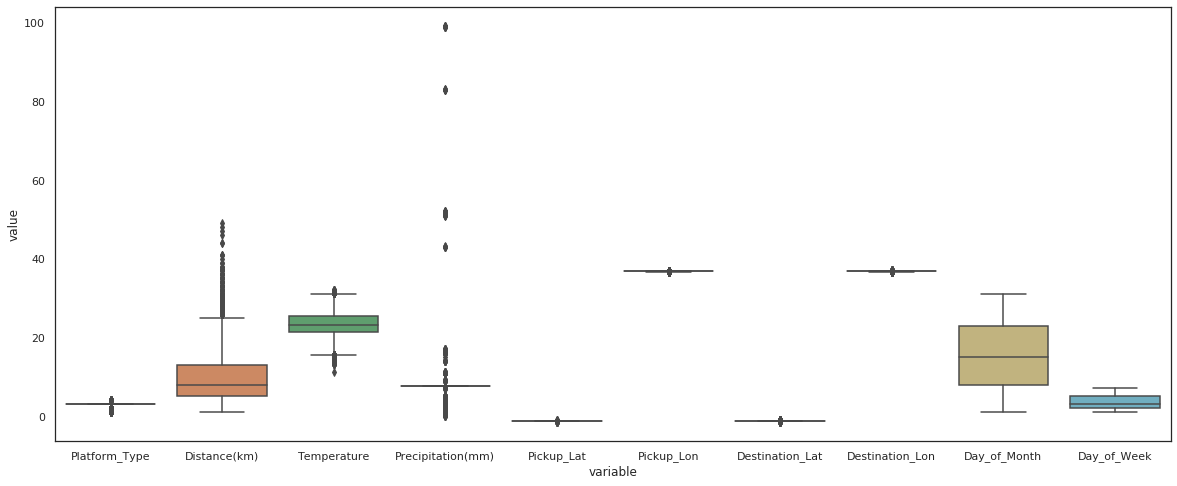

In [17]:
#Outliers Overview for numeric features

plt.figure(figsize=(20, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(full_df[numeric_cols]))
plt.show()

In [18]:
#Correlation between numeric features and the target variable
corr_matrix = full_df[:border][numeric_cols+['Time_Pic_Arr']].corr()
print(corr_matrix["Time_Pic_Arr"].sort_values(ascending=False))

Time_Pic_Arr         1.000000
Distance(km)         0.580608
Destination_Lon      0.070425
Pickup_Lon           0.060285
Day_of_Week          0.009693
Temperature          0.005779
Precipitation(mm)    0.003934
Platform_Type       -0.003827
Day_of_Month        -0.014710
Pickup_Lat          -0.053823
Destination_Lat     -0.061872
Name: Time_Pic_Arr, dtype: float64


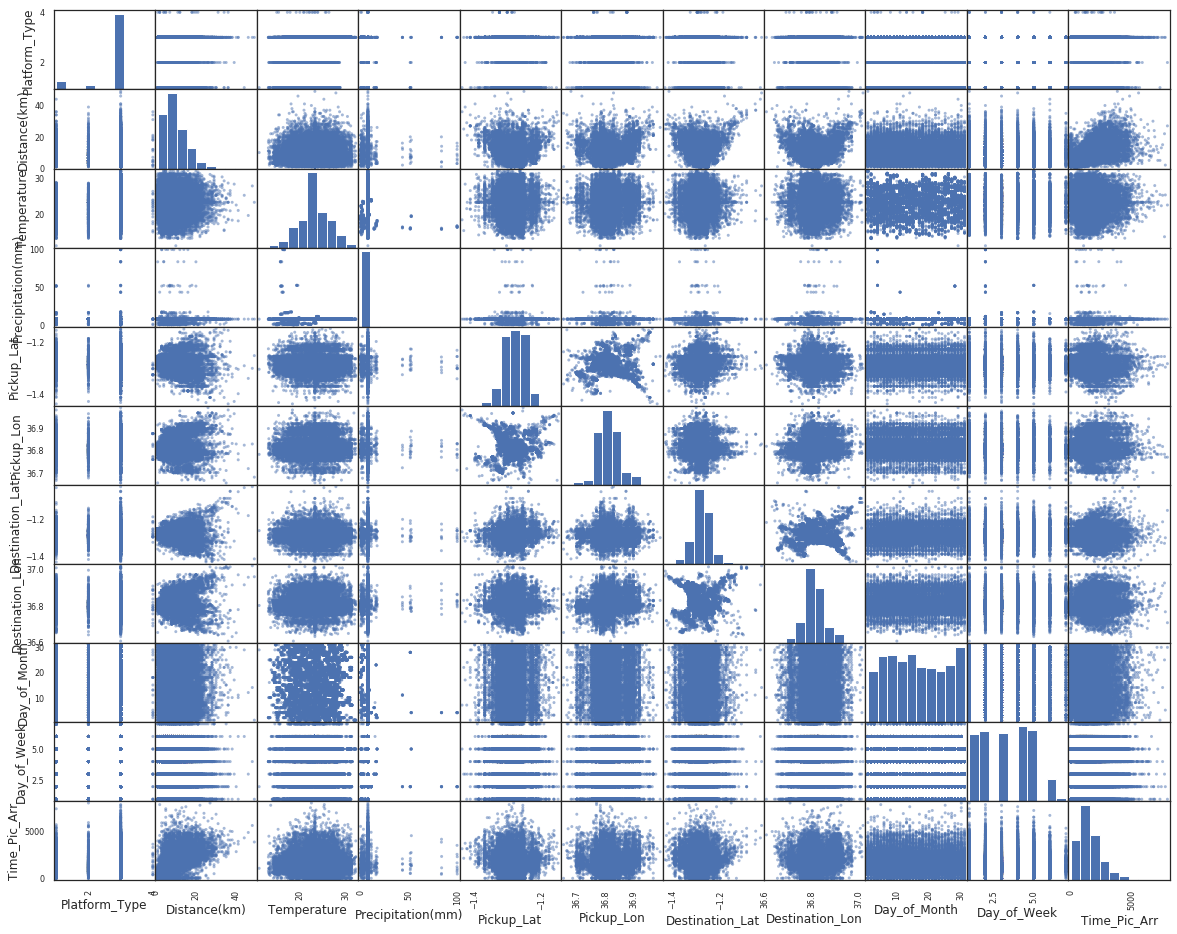

In [19]:
pd.plotting.scatter_matrix(full_df[:border][numeric_cols+['Time_Pic_Arr']], figsize=(20,16))
plt.show()

### Examinig the target (time from pickup to arrival at the destination)

In [20]:
#Useful statistics about our target column

full_df[:border]['Time_Pic_Arr'].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time_Pic_Arr, dtype: float64

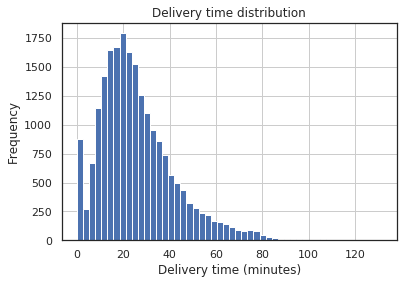

In [21]:
sendy_mins = full_df[:border]['Time_Pic_Arr'] / 60
sendy_mins.hist(bins=50)
plt.title("Delivery time distribution")
plt.xlabel("Delivery time (minutes)")
plt.ylabel("Frequency")
plt.show()

In [22]:
#Delivery times under a minute, is these ok?

under_one = full_df[:border][full_df[:border]['Time_Pic_Arr'] < 60]
times = ['Pla_Time', 'Arr_Pic_Time','Pickup_Time', 'Time_Pic_Arr']
under_one[times].head(3)

,Pla_Time,Arr_Pic_Time,Pickup_Time,Time_Pic_Arr
36,11:47:23,13:02:08,13:35:48,2.0
52,16:16:05,17:10:03,17:14:41,4.0
81,11:44:46,13:32:02,13:51:06,14.0


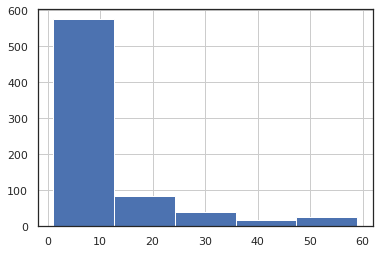

In [23]:
under_one['Time_Pic_Arr'].hist(bins=5)
#most deliveries under a minute are made within 10 seconds, this cant be right
#we can't drop these rows at this stage (these values could be in the test too)

## 4) Modelling

### Cross validation

In [24]:
features = numeric_cols + ['Personal_Business']

data_df = full_df[features]

y = full_df[:border]['Time_Pic_Arr']
train = data_df[:border]
test = data_df[border:]

test.head()

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week,Personal_Business
21201,3,8,23.255689,7.573502,-1.333275,36.870815,-1.305249,36.822390,27,3,0
21202,3,5,23.255689,7.573502,-1.272639,36.794723,-1.277007,36.823907,17,5,0
21203,3,5,22.800000,7.573502,-1.290894,36.822971,-1.276574,36.851365,27,4,0
21204,3,5,24.500000,7.573502,-1.290503,36.809646,-1.303382,36.790658,17,1,0
21205,3,6,24.400000,7.573502,-1.281081,36.814423,-1.266467,36.792161,11,2,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16960, 11) (4241, 11) (16960,) (4241,)


In [26]:
rs = 3
kfold = KFold(n_splits=10, random_state=rs, shuffle=True)

regressors = []
regressors.append(SVR())
regressors.append(GradientBoostingRegressor(random_state=rs))
regressors.append(ExtraTreesRegressor(n_estimators=rs))
regressors.append(RandomForestRegressor(random_state=rs))
regressors.append(xgb.XGBRegressor(random_state=rs, objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))

cv_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cv_results.append(np.sqrt(abs(cross_val_score(regressor, X_train, y=y_train, scoring='neg_mean_squared_error', cv=kfold))))

cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
cv_res = pd.DataFrame({ 
    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "XGBR", "LGBM"],
    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
                       })
cv_res = cv_res.sort_values("CrossValMeans", ascending=True)
print(cv_res)

  Algorithm  CrossValMeans  CrossValErrors
5      LGBM     779.699085       19.545577
4      XGBR     781.143223       19.301869
1       GBR     781.356688       18.974365
3       RFR     838.774043       21.695899
2       EXR     938.362683       15.277943
0       SVR     971.113591       19.013410


### Parameter Tuning

In [27]:
params = {
    'n_estimators':[75], # [75, 95],
    'num_leaves': [15], #[12,15, 17],
    'reg_alpha': [0.02], #[0.02, 0.05],
    'min_data_in_leaf': [300],  #[250, 280, 300]
    'learning_rate': [0.1], #[0.05, 0.1, 0.25],
    'objective': ['regression'] #['regression', None]
    }

lsearch = GridSearchCV(estimator = lgb.LGBMRegressor(random_state=rs), cv=kfold,scoring='neg_mean_squared_error', param_grid=params)
lgbm = lsearch.fit(X_train, y_train)

l_params = lgbm.best_params_
l_score = np.sqrt(abs(lgbm.best_score_))
print(lgbm.best_params_, np.sqrt(abs(lgbm.best_score_)))

#try: RandomSearch, hyperopt (bayesian)

{'learning_rate': 0.1, 'min_data_in_leaf': 300, 'n_estimators': 75, 'num_leaves': 15, 'objective': 'regression', 'reg_alpha': 0.02} 777.6242475773421


In [28]:
RFC = RandomForestRegressor(random_state=rs)
rf_param = {"max_depth":[None], "max_features":[3], "min_samples_split":[10],
           "min_samples_leaf": [3], "n_estimators":[300]}
rsearch = GridSearchCV(RFC, cv=kfold, scoring='neg_mean_squared_error',param_grid=rf_param)
rfm = rsearch.fit(X_train, y_train)

r_score = np.sqrt(abs(rfm.best_score_))
r_params = rfm.best_params_
print(r_score, r_params)

779.175846970017 {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}


### Evaluating models

In [29]:
def plot_learning_curve(estimator, title, X, y, ylim=None, n_jobs=-1, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generating a plot of test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Trainig examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error', shuffle=True)
    
    #scores - 5 runs, each with 10 fold
    train_scores_mean = -np.mean(train_scores, axis=1) #5 means (each size)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r' )
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt


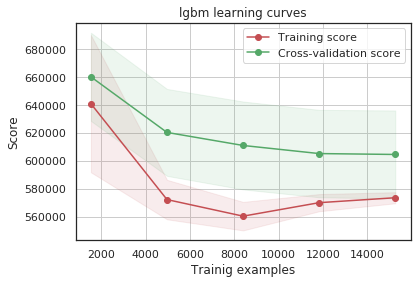

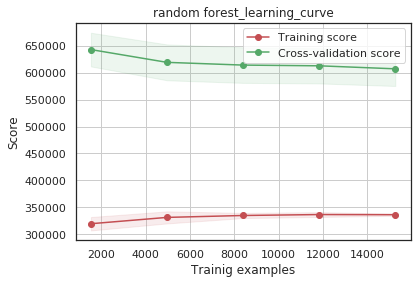

In [30]:
#Learning Curves

g = plot_learning_curve(lgbm.best_estimator_, "lgbm learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(rfm.best_estimator_, "random forest_learning_curve", X_train, y_train, cv=kfold)

#lgbm: mse error decreases drastically then levels at the train size of 12000 rows adding more data 
#will not improve the score significantly, in this case we try a diff approach (changing the data)
#rf: mse error decreases very slowly, this model would require a lot of data to improve score

## Feature importance

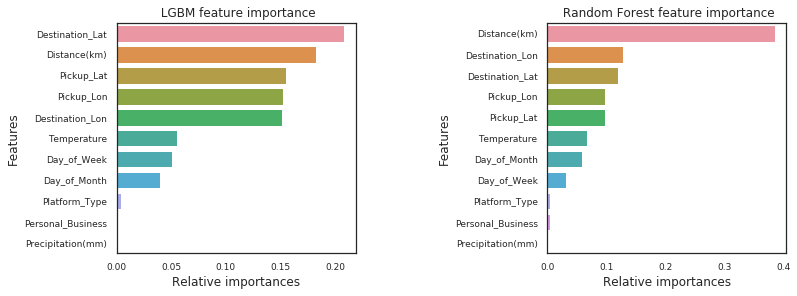

In [31]:
vals = lgbm.best_estimator_.feature_importances_
l_importance = np.array([ val/sum(vals) for val in vals ])
r_importance  = rfm.best_estimator_.feature_importances_
feats = np.array(features)

fig,axes = plt.subplots(1,2, figsize=(12, 8))
plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

indices = np.argsort(l_importance)[::-1]
g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=axes[0])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" LGBM feature importance")

index = np.argsort(r_importance)[::-1]
g = sns.barplot(y=feats[index], x=r_importance[index], orient='h', ax=axes[1])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" Random Forest feature importance")
plt.show()

### Training the Model and making a prediction

In [32]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lparams = {
           'learning_rate': 0.1, 'min_data_in_leaf': 300, 
           'n_estimators': 75, 'num_leaves': 20, 'random_state':rs,
           'objective': 'regression', 'reg_alpha': 0.02,
          'feature_fraction': 0.9, 'bagging_fraction':0.9}


lgbm = lgb.train(lparams, lgb_train, valid_sets=lgb_eval, num_boost_round=20, early_stopping_rounds=20)

lpred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

print("The RMSE of prediction is ", mean_squared_error(y_test, lpred)**0.5)


[1]	valid_0's l2: 893939
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 841883
[3]	valid_0's l2: 799518
[4]	valid_0's l2: 764996
[5]	valid_0's l2: 736810
[6]	valid_0's l2: 713355
[7]	valid_0's l2: 694408
[8]	valid_0's l2: 678394
[9]	valid_0's l2: 665780
[10]	valid_0's l2: 655149
[11]	valid_0's l2: 646518
[12]	valid_0's l2: 639578
[13]	valid_0's l2: 633298
[14]	valid_0's l2: 628181
[15]	valid_0's l2: 623493
[16]	valid_0's l2: 619754
[17]	valid_0's l2: 616892
[18]	valid_0's l2: 614122
[19]	valid_0's l2: 611253
[20]	valid_0's l2: 608603
[21]	valid_0's l2: 606684
[22]	valid_0's l2: 605267
[23]	valid_0's l2: 603666
[24]	valid_0's l2: 601817
[25]	valid_0's l2: 600414
[26]	valid_0's l2: 599457
[27]	valid_0's l2: 598404
[28]	valid_0's l2: 597771
[29]	valid_0's l2: 597129
[30]	valid_0's l2: 595949
[31]	valid_0's l2: 595455
[32]	valid_0's l2: 594757
[33]	valid_0's l2: 594220
[34]	valid_0's l2: 593820
[35]	valid_0's l2: 593142
[36]	valid_0's l2: 592803
[37]	valid_0

### Making a submission

In [33]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration)
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv("submission.csv", index=False)